In [107]:
from __future__ import division
from __future__ import print_function
import requests
import json
import urllib
import numpy as np
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
import matplotlib.pyplot as plt

In [108]:
locations = [(456, 320), # location 0 - the depot/origin
(228, 0),    # location 1
(912, 0),    # location 2
(0, 80),     # location 3
(114, 80),   # location 4
(570, 160),  # location 5
(798, 160),  # location 6
(342, 240),  # location 7
(684, 240),  # location 8
(570, 400),  # location 9
(912, 400),  # location 10
(114, 480),  # location 11
(228, 480),  # location 12
(342, 560),  # location 13
(684, 560),  # location 14
(0, 640),    # location 15
(798, 640)]  # location 16

In [109]:
x = list(zip(*locations))[0]
y = list(zip(*locations))[1]
z = [str(i) for i in range(17)]

## Problem:
### Nurses have to start from origin and go visit clients at their homes and come back to the origin at the end. What are the optimal routes considering number of nurses available?
## Formulation

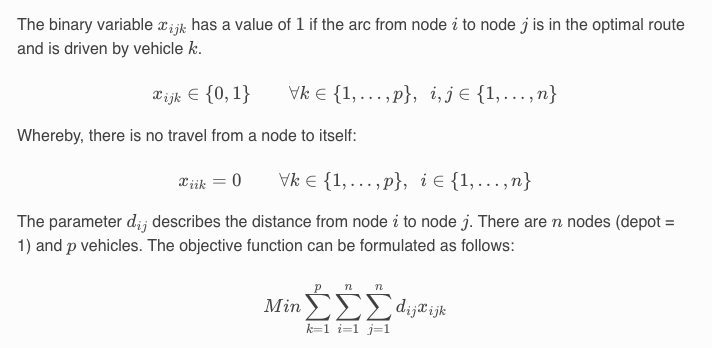

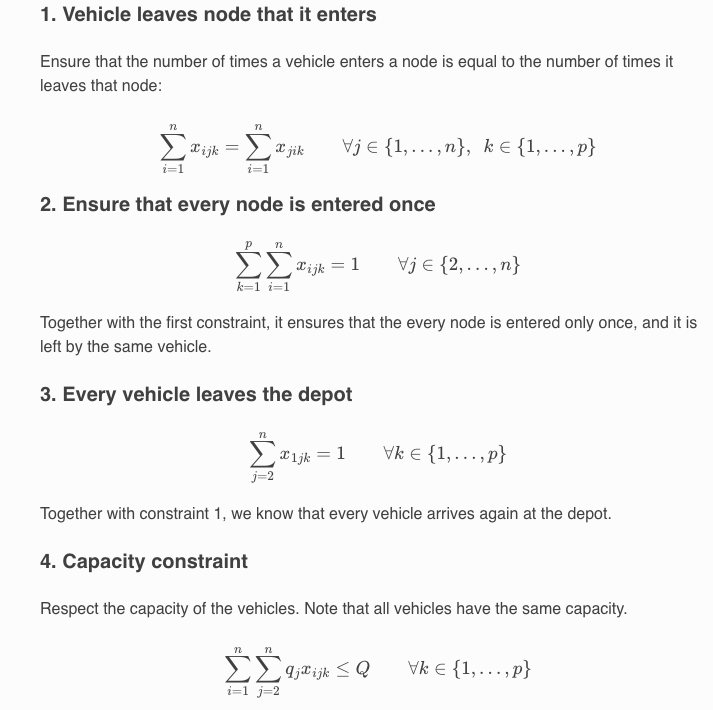

### **Capcity ignored for this model

## 16 Locations to Cover, Origin in Red (Distances in Meters)

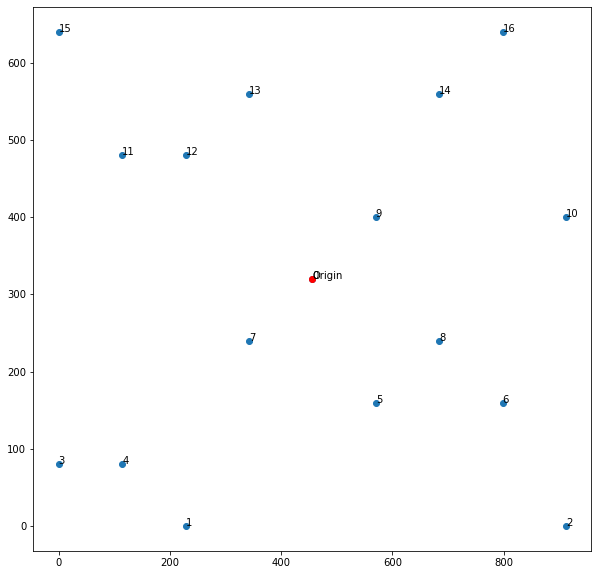

In [110]:
plt.scatter(x,y)
plt.scatter(456, 320, c = 'red')
plt.annotate("Origin", (456,320))

counter = 0
for xy in locations:
    plt.annotate(z[counter],xy)
    counter += 1

#plt.rcParams['figure.figsize'] = [10, 10]

plt.show()

## Create Distances 

In [111]:
def create_data_model():
    #distance_matrix: An array of distances between locations on meters.
    data = {}
    data['distance_matrix'] = [
        [
            0, 548, 776, 696, 582, 274, 502, 194, 308, 194, 536, 502, 388, 354,
            468, 776, 662
        ],
        [
            548, 0, 684, 308, 194, 502, 730, 354, 696, 742, 1084, 594, 480, 674,
            1016, 868, 1210
        ],
        [
            776, 684, 0, 992, 878, 502, 274, 810, 468, 742, 400, 1278, 1164,
            1130, 788, 1552, 754
        ],
        [
            696, 308, 992, 0, 114, 650, 878, 502, 844, 890, 1232, 514, 628, 822,
            1164, 560, 1358
        ],
        [
            582, 194, 878, 114, 0, 536, 764, 388, 730, 776, 1118, 400, 514, 708,
            1050, 674, 1244
        ],
        [
            274, 502, 502, 650, 536, 0, 228, 308, 194, 240, 582, 776, 662, 628,
            514, 1050, 708
        ],
        [
            502, 730, 274, 878, 764, 228, 0, 536, 194, 468, 354, 1004, 890, 856,
            514, 1278, 480
        ],
        [
            194, 354, 810, 502, 388, 308, 536, 0, 342, 388, 730, 468, 354, 320,
            662, 742, 856
        ],
        [
            308, 696, 468, 844, 730, 194, 194, 342, 0, 274, 388, 810, 696, 662,
            320, 1084, 514
        ],
        [
            194, 742, 742, 890, 776, 240, 468, 388, 274, 0, 342, 536, 422, 388,
            274, 810, 468
        ],
        [
            536, 1084, 400, 1232, 1118, 582, 354, 730, 388, 342, 0, 878, 764,
            730, 388, 1152, 354
        ],
        [
            502, 594, 1278, 514, 400, 776, 1004, 468, 810, 536, 878, 0, 114,
            308, 650, 274, 844
        ],
        [
            388, 480, 1164, 628, 514, 662, 890, 354, 696, 422, 764, 114, 0, 194,
            536, 388, 730
        ],
        [
            354, 674, 1130, 822, 708, 628, 856, 320, 662, 388, 730, 308, 194, 0,
            342, 422, 536
        ],
        [
            468, 1016, 788, 1164, 1050, 514, 514, 662, 320, 274, 388, 650, 536,
            342, 0, 764, 194
        ],
        [
            776, 868, 1552, 560, 674, 1050, 1278, 742, 1084, 810, 1152, 274,
            388, 422, 764, 0, 798
        ],
        [
            662, 1210, 754, 1358, 1244, 708, 480, 856, 514, 468, 354, 844, 730,
            536, 194, 798, 0
        ],
    ]
    data['num_nurses'] = 4
    data['origin'] = 0
    return data

## Random Assignment with 4 Nurses
### Written by hand

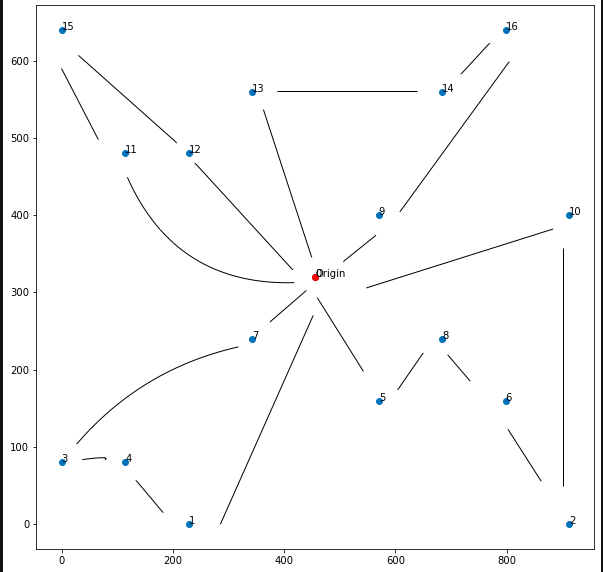

In [112]:
data = create_data_model()
distance_matrix = np.array(data['distance_matrix'])

In [119]:
route_1 = [0,7,3,4,1,0] 
route_2 = [0,11,15,12,0]
route_3 = [0,13,14,16,9,0]
route_4 = [0,10,2,6,8,5,0]

random_routes = [route_1, route_2, route_3, route_4]

def get_route_cost(route):
    i=0
    route_sum = 0
    while i < len(route) - 1:
        arc_cost = distance_matrix[ route[i], route[i+1] ]
        #print(arc_cost)
        route_sum += arc_cost
        i += 1
          
    print(route_sum)
    return route_sum

total_distance = 0
for route in random_routes:
    total_distance += get_route_cost(route)
    
print('Total Distance is ', total_distance)

1552
1552
1552
1872
Total Distance is  6528


## Optimizing 

In [114]:
def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    print(f'Objective: {solution.ObjectiveValue()}')
    total_distance = 0
    for nurse_id in range(data['num_nurses']):
        index = routing.Start(nurse_id)
        plan_output = 'Route for nurse {}:\n'.format(nurse_id)
        route_distance = 0
        while not routing.IsEnd(index):
            plan_output += ' {} -> '.format(manager.IndexToNode(index))
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, nurse_id)
        plan_output += '{}\n'.format(manager.IndexToNode(index))
        plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        print(plan_output)
        total_distance += route_distance
        
    print('Total Distance of all routes: {}m'.format(total_distance))


In [115]:
def main():
    """Entry point of the program."""
    # Instantiate the data problem.
    data = create_data_model()

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_nurses'], data['origin'])

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)


    # Create and register a transit callback.
    # the following function creates the distance callback, which returns the distances between locations, 
    #and passes it to the solver. It also sets the arc costs, which define the cost of travel, 
    #to be the distances of the arcs.
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add Distance constraint.
    dimension_name = 'Distance'
    routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        3000,  # Nurse maximum travel distance
        True,  # start cumul to zero
        dimension_name)
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(100)

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if solution:
        print_solution(data, manager, routing, solution)
    else:
        print('No solution found !')



In [116]:
main()

Objective: 161408
Route for nurse 0:
 0 ->  8 ->  6 ->  2 ->  5 -> 0
Distance of the route: 1552m

Route for nurse 1:
 0 ->  7 ->  1 ->  4 ->  3 -> 0
Distance of the route: 1552m

Route for nurse 2:
 0 ->  9 ->  10 ->  16 ->  14 -> 0
Distance of the route: 1552m

Route for nurse 3:
 0 ->  12 ->  11 ->  15 ->  13 -> 0
Distance of the route: 1552m

Total Distance of all routes: 6208m


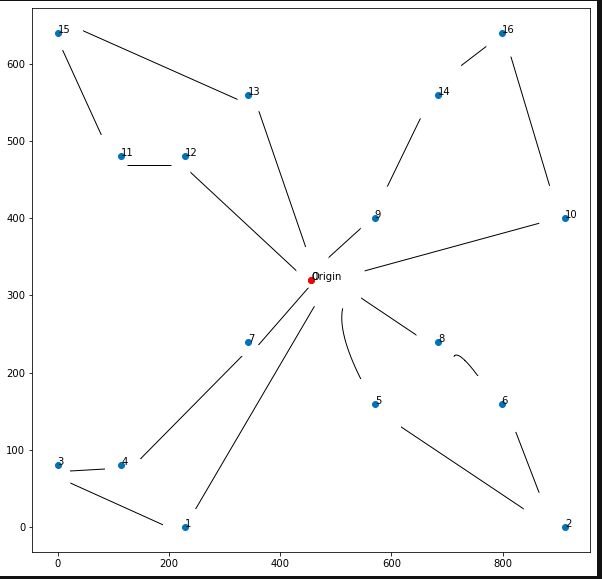

## In conclusion, the model saved 6,528 - 6,208 = 320m compared to a random human-made route.